In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import Compose, Normalize
from torchvision.transforms.functional import to_tensor
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt
import seaborn as sns


# modify to be much wider -> 1000
# iron out training

# simple convnet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.log_softmax(x)
        return output

    
# train loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses = []
    epoch_fracs = []
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            losses.append(loss.item())
            epoch_frac = (epoch - 1) + batch_idx / len(train_loader)
            epoch_fracs.append(epoch_frac)
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
    return epoch_fracs, losses
            
            
# test loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.sum(criterion(output, target)).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return  test_loss, 100. * correct / len(test_loader.dataset)


def run_train_test_loop(model: torch.nn.Module, model_name: str, epochs: int = 20):
    sns.set_style("darkgrid")
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    criterion = nn.CrossEntropyLoss()

    val_best = 0.
    val_accs = []
    val_losses = []
    train_losses = []
    train_iters = []
    val_epochs = []
    for epoch in tqdm(range(1, epochs + 1)):
        epoch_fracs, train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = test(model, device, test_loader, criterion)
        scheduler.step()

        train_iters.extend(epoch_fracs)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_losses.extend(train_loss)
        val_epochs.append(epoch)

        clear_output(True)
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.set_yscale('log')
        lns1_1 = ax1.plot(train_iters, train_losses, ".", label="train loss", color="y")
        lns1_0 = ax1.plot(val_epochs, val_losses, "o", label="validation loss")
        ax1.tick_params(axis='y')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:green'
        lns2 = ax2.plot(val_epochs, val_accs, "o", label="validation accuracy", color=color)
        ax2.set_ylabel('accuracy',)  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        leg = lns1_0 + lns1_1 + lns2
        labs = [l.get_label() for l in leg]
        ax1.legend(leg, labs, loc=0)
        plt.show()

        if val_acc > val_best:
            val_best = val_acc
            torch.save(model.state_dict(), f"models/{model_name}.pt")
    print(f"best acc: {val_best}")


In [2]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, num_workers = 4, pin_memory = True, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset2,  num_workers = 4, pin_memory = True, batch_size=32)

model = Net().to(device)

    
retrain = False
if retrain:
    run_train_test_loop(model, "mnist_cnn_tiny")    
else:
    model = Net().to(device).eval()
    state_dict = torch.load("models/mnist_cnn_tiny.pt",) # map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)


In [3]:
test(model, device, test_loader, nn.CrossEntropyLoss())


Test set: Average loss: 0.0010, Accuracy: 9902/10000 (99%)



(0.0009897034924675212, 99.02)

In [4]:
import torch
from torch import nn
from itertools import chain
from typing import Union
import torch
from model_chopping import get_children

In [165]:
from typing import Optional, Tuple


class LayerModifier(nn.Module):
    def __init__(
        self, 
        original_op: nn.Module, 
        dims: Tuple, 
        rand_ortho: Optional[torch.tensor] = None
    ):
        super(LayerModifier, self).__init__()
        if not rand_ortho:
            rand_ortho_weight = torch.nn.init.orthogonal_(torch.empty((dims, dims))).to(device)
            rand_ortho_weight = torch.nn.Parameter(rand_ortho_weight[..., None, None])
            rand_ortho_weight.requires_grad = False
            
            conv1x1_ortho = nn.Conv2d(in_channels=dims, out_channels=dims, kernel_size=1, bias=False)
            conv1x1_ortho.weight = rand_ortho_weight

        if isinstance(original_op, torch.nn.Conv2d):
            self.rand_ortho = lambda x: conv1x1_ortho(x)
        elif isinstance(original_op, torch.nn.Linear): # unsqueeze final two dims if linear
            self.rand_ortho = lambda x: conv1x1_ortho(x[..., None, None]).reshape(-1, dims)
        else:
            raise NotImplementedError(f"Only for linear and conv2d, not {type(original_op)}")
            
        self.original_op = original_op
    
    def forward(self, x):
        x = self.original_op(x)
        x = self.rand_ortho(x) 
        return x
    
    
# simple convnet
class NetModifier(nn.Module):
    def __init__(self, layer: Union[bool, int] = False):
        super(NetModifier, self).__init__()
        
        if layer >= 1:
            self.conv1 = LayerModifier(nn.Conv2d(1, 32, 3, 1).to(device), dims=32)
            for p in self.conv1.parameters():
                p.requires_grad = False
        else:
            self.conv1 = nn.Conv2d(1, 32, 3, 1)

        if layer >= 2:
            self.conv2 = LayerModifier(nn.Conv2d(32, 64, 3, 1).to(device), dims=64)
            for p in self.conv2.parameters():
                p.requires_grad = False
        else:
            self.conv2 = nn.Conv2d(32, 64, 3, 1)
                        
        if layer >= 3:
            self.fc1 = LayerModifier(nn.Linear(9216, 128).to(device), dims=128)
            for p in self.fc1.parameters():
                p.requires_grad = False
        else:
            self.fc1 = nn.Linear(9216, 128)
            
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.log_softmax(x)
        return output


## First, MNIST experiments without re-initialization.

In [98]:
net1 = NetModifier(layer=1).to(device)
state_dict = torch.load("models/mnist_cnn_tiny.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("conv1", "conv1.original_op"): v for k, v in state_dict.items()}
net1.load_state_dict(state_dict)

<All keys matched successfully>

In [99]:
# for p in model.parameters():
#     if p.requires_grad:
#         print(p.shape)

In [100]:
# for p in net1.parameters():
#     if p.requires_grad:
#         print(p.shape)

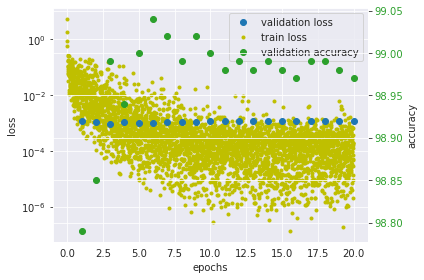

best acc: 99.04


In [101]:
run_train_test_loop(net1, "mnist_cnn_tiny_freeze_layer1_conv1x1")    


In [102]:
net2 = NetModifier(layer=2).to(device)
state_dict = torch.load("models/mnist_cnn_tiny_freeze_layer1_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("conv2", "conv2.original_op"): v for k, v in state_dict.items()}
net2.load_state_dict(state_dict)

<All keys matched successfully>

In [103]:
# for p in net2.parameters():
#     if p.requires_grad:
#         print(p.shape)

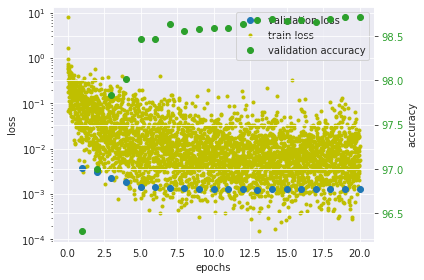

best acc: 98.71


In [104]:
run_train_test_loop(net2, "mnist_cnn_tiny_freeze_layer2_conv1x1")    


In [166]:
net3 = NetModifier(layer=3).to(device)
state_dict = torch.load("models/mnist_cnn_tiny_freeze_layer2_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("fc1", "fc1.original_op"): v for k, v in state_dict.items()}
net3.load_state_dict(state_dict)

<All keys matched successfully>

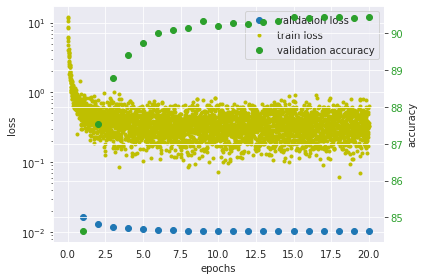

best acc: 90.44


In [167]:
run_train_test_loop(net3, "mnist_cnn_tiny_freeze_layer3_conv1x1")    


## Now, MNIST experiments *with* random initialization for layers > $i$

In [168]:
net1 = NetModifier(layer=1).to(device)
new_state_dict = net1.state_dict()
state_dict = torch.load("models/mnist_cnn_tiny.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("conv1", "conv1.original_op"): v for k, v in state_dict.items() if "conv1" in k}
new_state_dict.update(state_dict)
net1.load_state_dict(new_state_dict)

<All keys matched successfully>

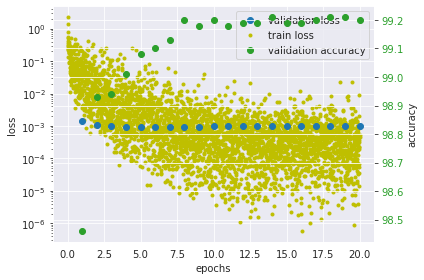

best acc: 99.21


In [169]:
run_train_test_loop(net1, "mnist_cnn_tiny_freeze_layer1_reinit_conv1x1")    

In [170]:
net2 = NetModifier(layer=2).to(device)
new_state_dict = net2.state_dict()
state_dict = torch.load("models/mnist_cnn_tiny_freeze_layer1_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("conv2", "conv2.original_op"): v for k, v in state_dict.items() if "conv2" in k}
new_state_dict.update(state_dict)
net2.load_state_dict(new_state_dict)

<All keys matched successfully>

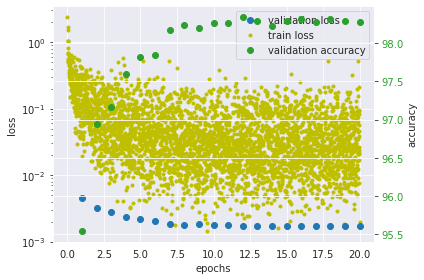

best acc: 98.34


In [171]:
run_train_test_loop(net2, "mnist_cnn_tiny_freeze_layer2_reinit_conv1x1")    

In [172]:
net3 = NetModifier(layer=3).to(device)
new_state_dict = net3.state_dict()
state_dict = torch.load("models/mnist_cnn_tiny_freeze_layer2_reinit_conv1x1.pt",) # map_location=torch.device('cpu'))]
# hacky as hell
state_dict = {k.replace("fc1", "fc1.original_op"): v for k, v in state_dict.items() if "fc1" in k}
new_state_dict.update(state_dict)
net3.load_state_dict(new_state_dict)

<All keys matched successfully>

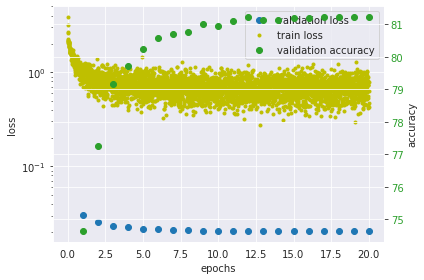

best acc: 81.22


In [173]:
run_train_test_loop(net3, "mnist_cnn_tiny_freeze_layer3_reinit_conv1x1")    

## How does the performance above compare to the case where I only train the final layer, w/ the rest of the model randomly initialized?

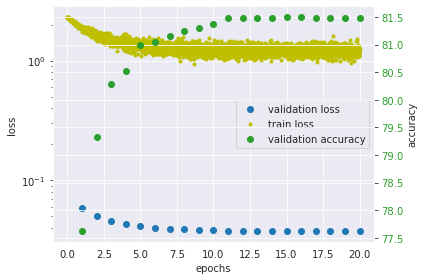

best acc: 81.5


In [55]:
model_fc2 = Net().to(device)
for p in model_fc2.parameters():
    p.requires_grad = False
model_fc2.fc2 = nn.Linear(128, 10).to(device)

    
run_train_test_loop(model_fc2, "mnist_cnn_tiny_only_fc2")    

## First layer frozen

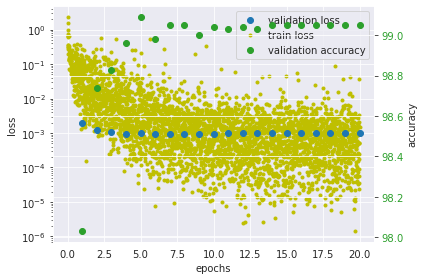

best acc: 99.09


In [174]:
model_fc_first_frozen = Net().to(device)
for p in model_fc_first_frozen.parameters():
    p.requires_grad = False
model_fc_first_frozen.conv2 = nn.Conv2d(32, 64, 3, 1).to(device)
model_fc_first_frozen.fc1 = nn.Linear(9216, 128).to(device)
model_fc_first_frozen.fc2 = nn.Linear(128, 10).to(device)

    
run_train_test_loop(model_fc_first_frozen, "mnist_cnn_first_frozen")    

## First two conv layers frozen


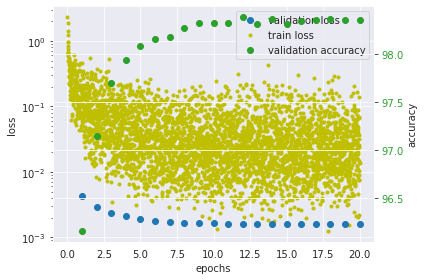

best acc: 98.38


In [175]:
model_fc_first_frozen = Net().to(device)
for p in model_fc_first_frozen.parameters():
    p.requires_grad = False
# model_fc_first_frozen.conv2 = nn.Conv2d(32, 64, 3, 1).to(device)
model_fc_first_frozen.fc1 = nn.Linear(9216, 128).to(device)
model_fc_first_frozen.fc2 = nn.Linear(128, 10).to(device)

    
run_train_test_loop(model_fc_first_frozen, "mnist_cnn_second_frozen")    